# AAPL stock price and option chain via yfinance

This notebook fetches Apple (AAPL) historical prices and the nearest-expiration options chain (calls and puts) using yfinance.

Fetched 549 rows of AAPL price data from 2023-06-13 to 2025-08-21 @ 1d
                                 Open        High         Low       Close  \
Date                                                                        
2025-08-14 00:00:00-04:00  234.059998  235.119995  230.850006  232.779999   
2025-08-15 00:00:00-04:00  234.000000  234.279999  229.339996  231.589996   
2025-08-18 00:00:00-04:00  231.699997  233.119995  230.110001  230.889999   
2025-08-19 00:00:00-04:00  231.279999  232.869995  229.350006  230.559998   
2025-08-20 00:00:00-04:00  229.979996  230.470001  225.770004  226.009995   

                            Adj Close    Volume  Dividends  Stock Splits  
Date                                                                      
2025-08-14 00:00:00-04:00  232.779999  51916300        0.0           0.0  
2025-08-15 00:00:00-04:00  231.589996  56038700        0.0           0.0  
2025-08-18 00:00:00-04:00  230.889999  37476200        0.0           0.0  
2025-08-19 00:

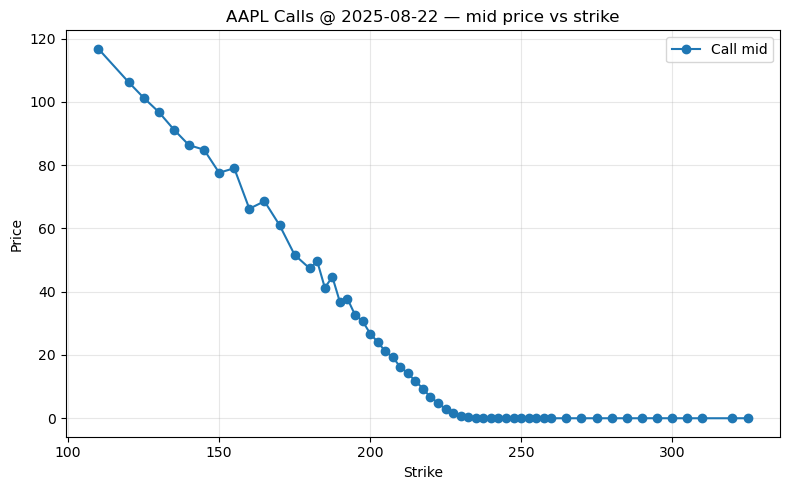

In [23]:
# Install yfinance if not already available (uncomment if needed)
# import sys, subprocess
# subprocess.check_call([sys.executable, "-m", "pip", "install", "yfinance", "pandas"])  # optional

import datetime as dt
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
TICKER = "AAPL"
START = (dt.date.today() - dt.timedelta(days=800)).isoformat()  # last 1y
END = dt.date.today().isoformat()
INTERVAL = "1d"  # choose from 1m, 5m, 15m, 1h, 1d, etc.

SAVE_CSV = False  # set True to save CSVs

# --- Fetch historical prices ---
tkr = yf.Ticker(TICKER)
price_df = tkr.history(start=START, end=END, interval=INTERVAL, auto_adjust=False)

print(f"Fetched {len(price_df)} rows of {TICKER} price data from {START} to {END} @ {INTERVAL}")
print(price_df.tail())

if SAVE_CSV:
    price_df.to_csv(f"{TICKER}_prices_{START}_to_{END}_{INTERVAL}.csv", index=True)

# --- Fetch option expirations ---
expirations = tkr.options
if not expirations:
    print("No option expirations available.")
    calls_df = pd.DataFrame()
    puts_df = pd.DataFrame()
else:
    # choose the nearest expiration
    next_exp = expirations[0]
    print(f"Using nearest expiration: {next_exp}")

    # --- Fetch option chain (calls and puts) ---
    opt_chain = tkr.option_chain(next_exp)
    calls_df = opt_chain.calls.copy()
    puts_df = opt_chain.puts.copy()

    # Helpful derived columns
    last_price = price_df["Close"].iloc[-1] if not price_df.empty else None
    if last_price is not None:
        calls_df["moneyness"] = calls_df["strike"] / last_price
        puts_df["moneyness"] = puts_df["strike"] / last_price

    # Show head
    print("\nCalls (head):")
    print(calls_df.head())
    print("\nPuts (head):")
    print(puts_df.head())

    if SAVE_CSV:
        calls_df.to_csv(f"{TICKER}_calls_{next_exp}.csv", index=False)
        puts_df.to_csv(f"{TICKER}_puts_{next_exp}.csv", index=False)

# --- Simple summaries ---
summary = {
    "ticker": TICKER,
    "start": START,
    "end": END,
    "interval": INTERVAL,
    "last_close": float(price_df["Close"].iloc[-1]) if not price_df.empty else None,
    "expirations_count": len(expirations) if expirations else 0,
    "nearest_exp": expirations[0] if expirations else None,
    "calls_rows": len(calls_df) if isinstance(calls_df, pd.DataFrame) else 0,
    "puts_rows": len(puts_df) if isinstance(puts_df, pd.DataFrame) else 0,
}

print("\nSummary:")
for k, v in summary.items():
    print(f"- {k}: {v}")

# --- Plot: Call mid price vs strike for nearest expiration ---
if isinstance(calls_df, pd.DataFrame) and not calls_df.empty:
    plot_df = calls_df[['strike']].copy()
    mid = pd.Series(np.nan, index=calls_df.index)
    if {'bid', 'ask'}.issubset(calls_df.columns):
        mask = calls_df['bid'].notna() & calls_df['ask'].notna() & (calls_df['bid'] > 0) & (calls_df['ask'] > 0)
        mid.loc[mask] = 0.5 * (calls_df.loc[mask, 'bid'] + calls_df.loc[mask, 'ask'])
    if 'lastPrice' in calls_df.columns:
        lp_mask = calls_df['lastPrice'].notna() & (calls_df['lastPrice'] > 0) & mid.isna()
        mid.loc[lp_mask] = calls_df.loc[lp_mask, 'lastPrice']
    plot_df['mid'] = mid
    plot_df = plot_df.dropna().sort_values('strike')

    if not plot_df.empty:
        plt.figure(figsize=(8, 5))
        plt.plot(plot_df['strike'], plot_df['mid'], marker='o', linestyle='-', color='tab:blue', label='Call mid')
        plt.xlabel('Strike')
        plt.ylabel('Price')
        plt.title(f'{TICKER} Calls @ {next_exp} — mid price vs strike')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print('No valid mid prices to plot for calls.')
else:
    print('No calls data to plot.')

In [24]:
# --- Black–Scholes pricing (with continuous dividend yield) ---
from math import log, sqrt, exp, erf
import numpy as np
import pandas as pd


def norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))


def black_scholes_price(S, K, T, r, sigma, option_type="call", q=0.0):
    """
    Black–Scholes price for European call/put with continuous dividend yield.

    S: spot price
    K: strike
    T: time to maturity in years
    r: risk-free rate (annual, continuous)
    sigma: volatility (annualized)
    option_type: 'call' or 'put'
    q: continuous dividend yield
    """
    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0:
        return np.nan
    d1 = (log(S / K) + (r - q + 0.5 * sigma * sigma) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    if option_type.lower() == "call":
        return S * exp(-q * T) * norm_cdf(d1) - K * exp(-r * T) * norm_cdf(d2)
    elif option_type.lower() == "put":
        return K * exp(-r * T) * norm_cdf(-d2) - S * exp(-q * T) * norm_cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")


# --- Choose strike and maturity ---
# Use last close as default strike and nearest expiration fetched above
last_close = float(price_df["Close"].iloc[-1]) if not price_df.empty else np.nan
DEFAULT_STRIKE = float(np.round(last_close)) if np.isfinite(last_close) else 100.0

if isinstance(expirations, (list, tuple)) and len(expirations) > 0:
    expiry_str = expirations[0]
else:
    # fallback: 30 days from today if no expirations available
    expiry_str = (pd.Timestamp.today() + pd.Timedelta(days=30)).date().isoformat()

# User-editable inputs
BS_STRIKE = DEFAULT_STRIKE
BS_EXPIRY = expiry_str  # 'YYYY-MM-DD'
RISK_FREE = 0.04        # annual, continuous comp approximation
DIV_YIELD = 0.0         # set to a small value if desired

# Try to estimate dividend yield from last 1y dividends (optional)
try:
    div = tkr.dividends
    if isinstance(div, pd.Series) and not div.empty and np.isfinite(last_close) and last_close > 0:
        last_year = pd.Timestamp.today() - pd.Timedelta(days=365)
        trailing_div = float(div[div.index >= last_year].sum())
        if trailing_div > 0:
            DIV_YIELD = min(trailing_div / last_close, 0.2)  # cap at 20% to avoid outliers
except Exception:
    pass

# Time to maturity in years
T_years = max((pd.to_datetime(BS_EXPIRY) - pd.Timestamp.today()).days / 365.0, 1.0 / 365.0)

# Volatility: prefer implied vol near strike, fallback to historical
sigma = np.nan
try:
    if 'calls_df' in globals() and isinstance(calls_df, pd.DataFrame) and not calls_df.empty and 'impliedVolatility' in calls_df:
        # pick row with strike closest to BS_STRIKE
        idx = (calls_df['strike'] - BS_STRIKE).abs().idxmin()
        iv = float(calls_df.loc[idx, 'impliedVolatility'])
        if np.isfinite(iv) and iv > 0:
            sigma = iv
except Exception:
    pass

if not np.isfinite(sigma):
    # 20-day historical vol
    try:
        rets = price_df['Close'].pct_change().dropna()
        sigma_hist = float(rets.tail(20).std() * np.sqrt(252))
        sigma = sigma_hist if sigma_hist > 0 else 0.2
    except Exception:
        sigma = 0.2

S = last_close
K = float(BS_STRIKE)
T = float(T_years)
r = float(RISK_FREE)
q = float(DIV_YIELD)

call_price = black_scholes_price(S, K, T, r, sigma, option_type="call", q=q)
put_price = black_scholes_price(S, K, T, r, sigma, option_type="put", q=q)

print("Black–Scholes inputs:")
print(f"S={S:.4f}, K={K:.4f}, T={T:.6f}y, r={r:.4f}, q={q:.4f}, sigma={sigma:.4f}")
print(f"Expiry: {BS_EXPIRY}")
print("\nPrices:")
print(f"Call: {call_price:.4f}")
print(f"Put : {put_price:.4f}")

# Optional: compare to option chain mid for nearest strike
try:
    if 'calls_df' in globals() and isinstance(calls_df, pd.DataFrame) and not calls_df.empty:
        row = calls_df.loc[idx]
        if {'bid', 'ask'}.issubset(row.index):
            mid = (float(row['bid']) + float(row['ask'])) / 2 if np.isfinite(row['bid']) and np.isfinite(row['ask']) else np.nan
            print(f"\nMarket call mid (nearest strike {row['strike']}): {mid}")
except Exception:
    pass




Black–Scholes inputs:
S=226.0100, K=226.0000, T=0.002740y, r=0.0400, q=0.0000, sigma=0.0000
Expiry: 2025-08-22

Prices:
Call: 0.0348
Put : 0.0000

Market call mid (nearest strike 225.0): 0.0


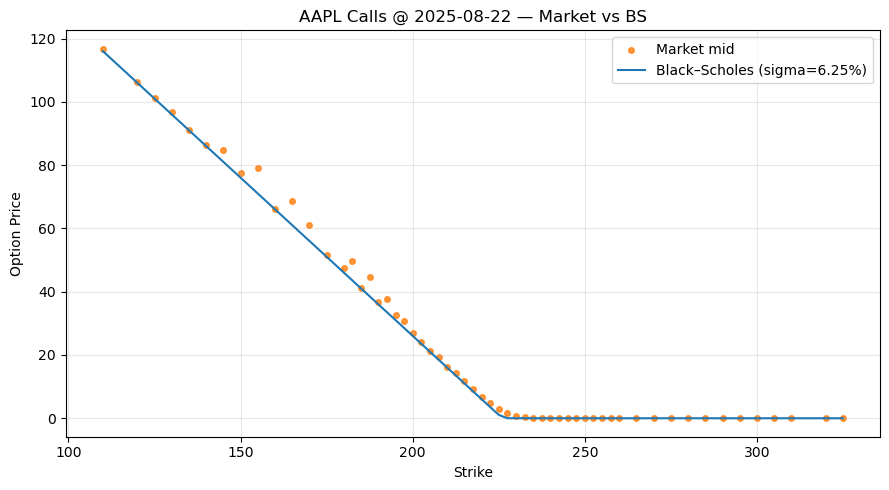

{'sigma_used': 0.062509375, 'T_years': 0.0027397260273972603, 'r': 0.04, 'q': 0.0, 'MAE': 1.095325688854568, 'MAPE_%': 48.70184174055435, 'n_points': 58}


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Cross-sectional: Price vs Strike (Market vs Black–Scholes) ---

# Config
opt_type = 'call'  # 'call' or 'put'
expiry_to_use = BS_EXPIRY if 'BS_EXPIRY' in globals() else (next_exp if 'next_exp' in globals() else (expirations[0] if expirations else None))
if expiry_to_use is None:
    raise RuntimeError('No option expiry available to plot.')

# Load chain for the selected expiry if needed
try:
    if 'next_exp' in globals() and str(expiry_to_use) == str(next_exp) and 'calls_df' in globals() and 'puts_df' in globals():
        cdf = calls_df.copy()
        pdf = puts_df.copy()
    else:
        oc = tkr.option_chain(str(expiry_to_use))
        cdf = oc.calls.copy()
        pdf = oc.puts.copy()
except Exception as e:
    raise RuntimeError(f'Failed to fetch option chain for {expiry_to_use}: {e}')

chain_df = cdf if opt_type == 'call' else pdf
if chain_df.empty:
    raise RuntimeError(f'Empty chain for {opt_type} @ {expiry_to_use}')

# Market mid per strike
df = chain_df[['strike']].copy()
mid = pd.Series(np.nan, index=chain_df.index)
if {'bid','ask'}.issubset(chain_df.columns):
    mask = chain_df['bid'].notna() & chain_df['ask'].notna() & (chain_df['bid'] > 0) & (chain_df['ask'] > 0)
    mid.loc[mask] = 0.5 * (chain_df.loc[mask, 'bid'] + chain_df.loc[mask, 'ask'])
if 'lastPrice' in chain_df.columns:
    lp_mask = chain_df['lastPrice'].notna() & (chain_df['lastPrice'] > 0) & mid.isna()
    mid.loc[lp_mask] = chain_df.loc[lp_mask, 'lastPrice']

df['market_mid'] = mid

# Inputs for BS curve
S = float(price_df['Close'].iloc[-1]) if not price_df.empty else np.nan
if not np.isfinite(S):
    raise RuntimeError('Invalid spot price S.')

# Dividend yield: use existing or estimate from trailing dividends
q = float(DIV_YIELD) if 'DIV_YIELD' in globals() else 0.0
try:
    div = tkr.dividends
    if isinstance(div, pd.Series) and not div.empty and S > 0:
        last_year = pd.Timestamp.today() - pd.Timedelta(days=365)
        trailing_div = float(div[div.index >= last_year].sum())
        if trailing_div > 0 and 'DIV_YIELD' not in globals():
            q = min(trailing_div / S, 0.2)
except Exception:
    pass

r = float(RISK_FREE) if 'RISK_FREE' in globals() else 0.04
T = max((pd.to_datetime(str(expiry_to_use)) - pd.Timestamp.today()).days / 365.0, 1.0/365.0)

# Sigma: prefer ATM IV but guard against tiny/invalid values; fallback to local-median IV or 20d hist vol
sigma_ref = np.nan
valid_lo, valid_hi = 0.005, 3.0  # accept 0.5% to 300%
try:
    if 'impliedVolatility' in chain_df.columns and chain_df['impliedVolatility'].notna().any():
        iv_col = pd.to_numeric(chain_df['impliedVolatility'], errors='coerce')
        # ATM selection
        idx_atm = (chain_df['strike'] - S).abs().idxmin()
        iv_atm = float(iv_col.loc[idx_atm]) if idx_atm in iv_col.index else np.nan
        # Use ATM IV if in a reasonable range
        if np.isfinite(iv_atm) and (valid_lo <= iv_atm <= valid_hi):
            sigma_ref = iv_atm
        else:
            # Try a local median across nearest strikes to ATM
            nearest_idx = (chain_df['strike'] - S).abs().sort_values().index[:7]
            local_ivs = iv_col.loc[nearest_idx]
            local_ivs = local_ivs[(local_ivs >= valid_lo) & (local_ivs <= valid_hi)]
            if local_ivs.notna().any():
                sigma_ref = float(local_ivs.median())
except Exception:
    pass

if not np.isfinite(sigma_ref):
    try:
        rets = price_df['Close'].pct_change().dropna()
        sigma_hist = float(rets.tail(20).std() * np.sqrt(252))
        sigma_ref = sigma_hist if sigma_hist > 0 else 0.20
    except Exception:
        sigma_ref = 0.20

# Model price for each strike (flat sigma)
strikes = np.array(df['strike'], dtype=float)
model_prices = np.array([
    black_scholes_price(S, k, T, r, sigma_ref, option_type=opt_type, q=q) for k in strikes
])

df['model'] = model_prices

# Clean and sort
plot_df = df.dropna(subset=['market_mid']).copy()
plot_df = plot_df.sort_values('strike')

plt.figure(figsize=(9, 5))
plt.scatter(plot_df['strike'], plot_df['market_mid'], s=16, color='tab:orange', alpha=0.8, label='Market mid')
plt.plot(df['strike'].sort_values(), df.set_index('strike').loc[df['strike'].sort_values(), 'model'], color='tab:blue', label=f'Black–Scholes (sigma={sigma_ref:.2%})')
plt.xlabel('Strike')
plt.ylabel('Option Price')
plt.title(f'{TICKER} {opt_type.capitalize()}s @ {pd.to_datetime(str(expiry_to_use)).date()} — Market vs BS')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Basic error metrics on matched strikes
joined = plot_df[['strike', 'market_mid']].merge(df[['strike','model']], on='strike', how='inner').dropna()
if not joined.empty:
    mae = float(np.mean(np.abs(joined['model'] - joined['market_mid'])))
    mape = float(np.mean(np.abs(joined['model'] - joined['market_mid']) / np.maximum(joined['market_mid'], 1e-8)) * 100)
    print({'sigma_used': sigma_ref, 'T_years': T, 'r': r, 'q': q, 'MAE': mae, 'MAPE_%': mape, 'n_points': int(len(joined))})
else:
    print('No overlapping strikes with valid market mids for error stats.')

C:\Users\abcgi\AppData\Local\Temp\ipykernel_31676\541239718.py:124: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


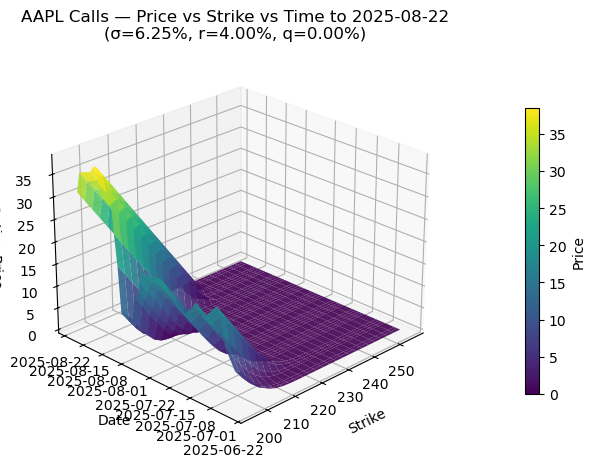

{'expiry': '2025-08-22', 'points': 1000, 'sigma_used': 0.062509375}


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)

# --- 3D surface: Option Price vs Strike vs Time (Black–Scholes model) ---

# Config
opt_type = 'call'  # 'call' or 'put'
N_DAYS = 40       # number of dates leading up to expiry
N_STRIKES = 25    # number of strikes around ATM to include

# Resolve expiry
expiry_ts = pd.to_datetime(BS_EXPIRY) if 'BS_EXPIRY' in globals() else (
    pd.to_datetime(next_exp) if 'next_exp' in globals() else (
        pd.to_datetime(expirations[0]) if 'expirations' in globals() and expirations else pd.Timestamp.today() + pd.Timedelta(days=30)
    )
)

# Select chain for expiry
try:
    if 'next_exp' in globals() and str(expiry_ts.date()) == str(next_exp) and 'calls_df' in globals() and 'puts_df' in globals():
        cdf = calls_df.copy(); pdf = puts_df.copy()
    else:
        oc = tkr.option_chain(str(expiry_ts.date()))
        cdf = oc.calls.copy(); pdf = oc.puts.copy()
except Exception as e:
    raise RuntimeError(f'Failed to fetch option chain for {expiry_ts.date()}: {e}')

chain_df = cdf if opt_type == 'call' else pdf
if chain_df.empty:
    raise RuntimeError('Empty option chain; cannot build 3D surface.')

# Spot series and dates window (tz-naive)
idx = price_df.index
dates_idx = idx.tz_convert(None) if getattr(idx, 'tz', None) is not None else idx
close_series = price_df['Close'].copy(); close_series.index = dates_idx

mask = (dates_idx <= expiry_ts) & (dates_idx >= (expiry_ts - pd.Timedelta(days=180)))
dates_sel = dates_idx[mask].tolist()[-N_DAYS:]
if not dates_sel:
    dates_sel = [d for d in dates_idx[-N_DAYS:] if d <= expiry_ts]
if not dates_sel:
    raise RuntimeError('No dates available before expiry for 3D plot.')

# Strike grid: choose around ATM
S_last = float(close_series.loc[dates_sel[-1]]) if dates_sel[-1] in close_series.index else float(close_series.iloc[-1])
strikes_all = np.array(sorted(pd.to_numeric(chain_df['strike'], errors='coerce').dropna().unique()))
if strikes_all.size:
    order = np.argsort(np.abs(strikes_all - S_last))
    strikes = np.sort(strikes_all[order[:min(N_STRIKES, strikes_all.size)]])
else:
    # fallback synthetic strikes
    strikes = np.linspace(0.7 * S_last, 1.3 * S_last, N_STRIKES)

# Rates and dividend yield
r = float(RISK_FREE) if 'RISK_FREE' in globals() else 0.04
q = float(DIV_YIELD) if 'DIV_YIELD' in globals() else 0.0

# Volatility choice: reuse sigma_ref if available; else robust ATM median or hist vol
sigma_use = None
if 'sigma_ref' in globals() and np.isfinite(sigma_ref) and sigma_ref > 0:
    sigma_use = float(sigma_ref)
else:
    sigma_use = np.nan
    valid_lo, valid_hi = 0.005, 3.0
    try:
        if 'impliedVolatility' in chain_df.columns and chain_df['impliedVolatility'].notna().any():
            iv_col = pd.to_numeric(chain_df['impliedVolatility'], errors='coerce')
            idx_atm = (chain_df['strike'] - S_last).abs().idxmin()
            iv_atm = float(iv_col.loc[idx_atm]) if idx_atm in iv_col.index else np.nan
            if np.isfinite(iv_atm) and (valid_lo <= iv_atm <= valid_hi):
                sigma_use = iv_atm
            else:
                nearest_idx = (chain_df['strike'] - S_last).abs().sort_values().index[:7]
                local_ivs = iv_col.loc[nearest_idx]
                local_ivs = local_ivs[(local_ivs >= valid_lo) & (local_ivs <= valid_hi)]
                if local_ivs.notna().any():
                    sigma_use = float(local_ivs.median())
    except Exception:
        pass
    if not np.isfinite(sigma_use):
        try:
            rets = close_series.pct_change().dropna()
            sigma_hist = float(rets.tail(20).std() * np.sqrt(252))
            sigma_use = sigma_hist if sigma_hist > 0 else 0.20
        except Exception:
            sigma_use = 0.20

# Build BS price surface Z[time, strike]
Y_dates_num = mdates.date2num(dates_sel)
X_strikes, Y_times = np.meshgrid(strikes, Y_dates_num)
Z_prices = np.full_like(X_strikes, np.nan, dtype=float)

for i, d in enumerate(dates_sel):
    S_t = float(close_series.loc[d]) if d in close_series.index else np.nan
    if not np.isfinite(S_t):
        continue
    T_t = max((expiry_ts - pd.Timestamp(d)).days / 365.0, 1.0/365.0)
    for j, K in enumerate(strikes):
        Z_prices[i, j] = black_scholes_price(S_t, float(K), float(T_t), r, sigma_use, option_type=opt_type, q=q)

# Plot 3D surface
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_strikes, Y_times, Z_prices, cmap='viridis', linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel('Strike')
ax.set_ylabel('Date')
ax.set_zlabel('Option Price')
ax.set_title(f'{TICKER} {opt_type.capitalize()}s — Price vs Strike vs Time to {expiry_ts.date()}\n(σ={sigma_use:.2%}, r={r:.2%}, q={q:.2%})')

# Format date axis
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate(rotation=0)

# Colorbar
m = plt.cm.ScalarMappable(cmap='viridis')
m.set_array(Z_prices)
fig.colorbar(m, ax=ax, shrink=0.7, pad=0.1, label='Price')

ax.view_init(elev=25, azim=-135)
plt.tight_layout()
plt.show()

print({'expiry': str(expiry_ts.date()), 'points': int(np.isfinite(Z_prices).sum()), 'sigma_used': sigma_use})